In [1]:
# 라이브러리 버전 확인
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [2]:
# 데이터 준비와 확인
import pandas as pd

train_data = pd.read_table("~/aiffel/sentiment_classification/data/ratings_train.txt")
test_data = pd.read_table("~/aiffel/sentiment_classification/data/ratings_test.txt")

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴 

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words):
    
    # 중복 데이터 제거
    train_data.drop_duplicates(subset = ['document'], inplace = True)
    test_data.drop_duplicates(subset = ['document'], inplace = True)
    
    # NaN 결측치 제거
    train_data.dropna(axis = 0, how = 'any', inplace = True)
    test_data.dropna(axis = 0, how = 'any', inplace = True)
    
    # 한국어 토크나이저로 토큰화 수행
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words = 10000)
    

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# Sentence Encoder
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# Sentence Decoder
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join([index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [7]:
get_decoded_sentence(X_train[0], index_to_word)

'아 더 빙 . . 진짜 짜증 나 네요 목소리'

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가 

In [8]:
import numpy as np

total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print(f"avg length: {np.mean(num_tokens)}")
print(f"max length: {np.max(num_tokens)}")
print(f"std length: {np.std(num_tokens)}")

avg length: 15.96940191154864
max length: 116
std length: 12.843571191092


In [9]:
# IQR 활용해서 Q3 + 1.5IQR 값을 Max Length 값으로 활용
Q1 = np.quantile(num_tokens, 0.25)
Q3 = np.quantile(num_tokens, 0.75)
IQR = Q3 - Q1
max_length = int(Q3 + 1.5*IQR)
max_length

37

In [10]:
np.sum(num_tokens < max_length) / len(num_tokens)

0.914993933623086

- 전체의 91.5%가 max_length 설정값 이내에 포함됨

In [11]:
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = 'post', maxlen = max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value = word_to_index["<PAD>"], padding = 'post', maxlen = max_length)

X_train.shape, X_test.shape

((146182, 37), (49157, 37))

# 4) 모델 구성 및 Validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험 진행 

In [12]:
# validation set 구성
X_val = X_train[:20000]
y_val = y_train[:20000]

partial_X_train = X_train[20000:]
partial_y_train = y_train[20000:]

partial_X_train.shape, partial_y_train.shape, X_val.shape, y_val.shape

((126182, 37), (126182,), (20000, 37), (20000,))

## 4-1) RNN

In [13]:
len(word_to_index)

10000

In [14]:
vocab_size = 10000
word_vector_dim = 32

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model_rnn.add(tf.keras.layers.LSTM(128))
model_rnn.add(tf.keras.layers.Dense(32, activation = "relu"))
model_rnn.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 406,593
Trainable params: 406,593
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model_rnn.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)

In [16]:
model_rnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
epochs = 100
history_rnn = model_rnn.fit(partial_X_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (X_val, y_val), callbacks = [checkpoint], verbose= 0)


Epoch 00001: val_accuracy improved from -inf to 0.84145, saving model to best_model_rnn.keras

Epoch 00002: val_accuracy improved from 0.84145 to 0.84685, saving model to best_model_rnn.keras

Epoch 00003: val_accuracy did not improve from 0.84685

Epoch 00004: val_accuracy improved from 0.84685 to 0.85110, saving model to best_model_rnn.keras

Epoch 00005: val_accuracy improved from 0.85110 to 0.85375, saving model to best_model_rnn.keras

Epoch 00006: val_accuracy did not improve from 0.85375

Epoch 00007: val_accuracy did not improve from 0.85375

Epoch 00008: val_accuracy did not improve from 0.85375

Epoch 00009: val_accuracy did not improve from 0.85375

Epoch 00010: val_accuracy did not improve from 0.85375

Epoch 00011: val_accuracy did not improve from 0.85375

Epoch 00012: val_accuracy did not improve from 0.85375

Epoch 00013: val_accuracy did not improve from 0.85375

Epoch 00014: val_accuracy did not improve from 0.85375

Epoch 00015: val_accuracy did not improve from 0.8

In [18]:
from tensorflow.keras.models import load_model

model_rnn = load_model("best_model_rnn.keras")
results_rnn = model_rnn.evaluate(X_test, y_test, verbose = 2)
results_rnn

1537/1537 - 4s - loss: 0.3555 - accuracy: 0.8492


[0.35550984740257263, 0.8492178320884705]

## 4-2) Conv-1D

In [19]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model_cnn.add(tf.keras.layers.Conv1D(128, 7, activation = "relu"))
model_cnn.add(tf.keras.layers.MaxPooling1D())
model_cnn.add(tf.keras.layers.Conv1D(128, 7, activation = "relu"))
model_cnn.add(tf.keras.layers.MaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(32, activation = "relu"))
model_cnn.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         28800     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 32)          4128      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)          

In [21]:
model_cnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint = ModelCheckpoint("best_model_cnn.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)
history_cnn = model_cnn.fit(partial_X_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (X_val, y_val), callbacks = [checkpoint], verbose = 0)


Epoch 00001: val_accuracy improved from -inf to 0.73131, saving model to best_model_cnn.keras

Epoch 00002: val_accuracy improved from 0.73131 to 0.73211, saving model to best_model_cnn.keras

Epoch 00003: val_accuracy improved from 0.73211 to 0.73736, saving model to best_model_cnn.keras

Epoch 00004: val_accuracy did not improve from 0.73736

Epoch 00005: val_accuracy did not improve from 0.73736

Epoch 00006: val_accuracy did not improve from 0.73736

Epoch 00007: val_accuracy did not improve from 0.73736

Epoch 00008: val_accuracy did not improve from 0.73736

Epoch 00009: val_accuracy did not improve from 0.73736

Epoch 00010: val_accuracy did not improve from 0.73736

Epoch 00011: val_accuracy did not improve from 0.73736

Epoch 00012: val_accuracy did not improve from 0.73736

Epoch 00013: val_accuracy did not improve from 0.73736

Epoch 00014: val_accuracy did not improve from 0.73736

Epoch 00015: val_accuracy did not improve from 0.73736

Epoch 00016: val_accuracy did not im

In [22]:
model_cnn = load_model("best_model_cnn.keras")
results_cnn = model_cnn.evaluate(X_test, y_test)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.4822 - accuracy: 0.7362


## 4-3) Global MaxPooling

In [23]:
model_mp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_mp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_mp.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint = ModelCheckpoint("best_model_gmp.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)
history_mp = model_mp.fit(partial_X_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (X_val, y_val),callbacks = [checkpoint], verbose = 0)


Epoch 00001: val_accuracy improved from -inf to 0.84030, saving model to best_model_gmp.keras

Epoch 00002: val_accuracy improved from 0.84030 to 0.85015, saving model to best_model_gmp.keras

Epoch 00003: val_accuracy improved from 0.85015 to 0.85200, saving model to best_model_gmp.keras

Epoch 00004: val_accuracy did not improve from 0.85200

Epoch 00005: val_accuracy did not improve from 0.85200

Epoch 00006: val_accuracy did not improve from 0.85200

Epoch 00007: val_accuracy did not improve from 0.85200

Epoch 00008: val_accuracy did not improve from 0.85200

Epoch 00009: val_accuracy did not improve from 0.85200

Epoch 00010: val_accuracy did not improve from 0.85200

Epoch 00011: val_accuracy did not improve from 0.85200

Epoch 00012: val_accuracy did not improve from 0.85200

Epoch 00013: val_accuracy did not improve from 0.85200

Epoch 00014: val_accuracy did not improve from 0.85200

Epoch 00015: val_accuracy did not improve from 0.85200

Epoch 00016: val_accuracy did not im

In [25]:
model_mp = load_model("best_model_gmp.keras")
results_mp = model_mp.evaluate(X_test, y_test)

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3552 - accuracy: 0.8452


# 6) Loss, Accuracy 그래프 시각화 

In [26]:
import matplotlib.pyplot as plt

def draw_history(history, epochs, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, epochs + 1)
    
    plt.figure(figsize = (15, 7))
    
    plt.subplot(121)
    plt.plot(epochs, acc, '--b',  label = 'Training')
    plt.plot(epochs, val_acc, 'b', label = "Valdation")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, '--b',  label = 'Training')
    plt.plot(epochs, val_loss, 'b', label = "Valdation")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.suptitle(f"Training result of model: {model_name}", fontsize = 20)
    
    plt.show()
    

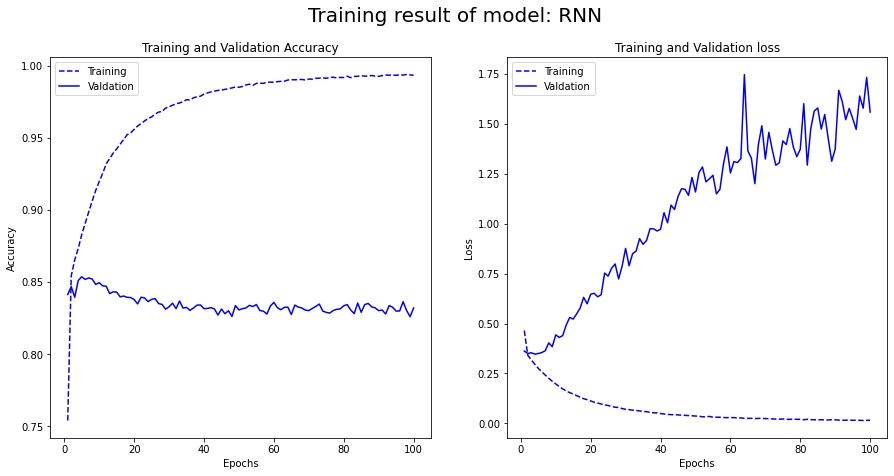

In [27]:
draw_history(history_rnn, epochs, 'RNN')

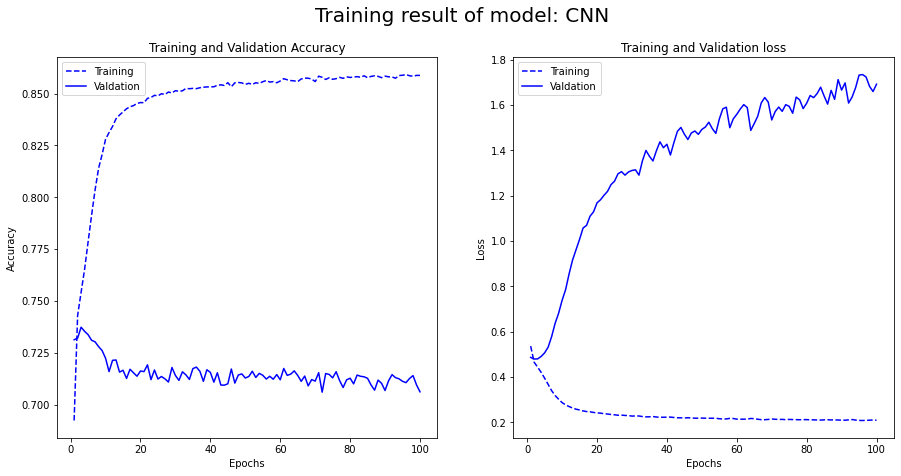

In [28]:
draw_history(history_cnn, epochs, "CNN")

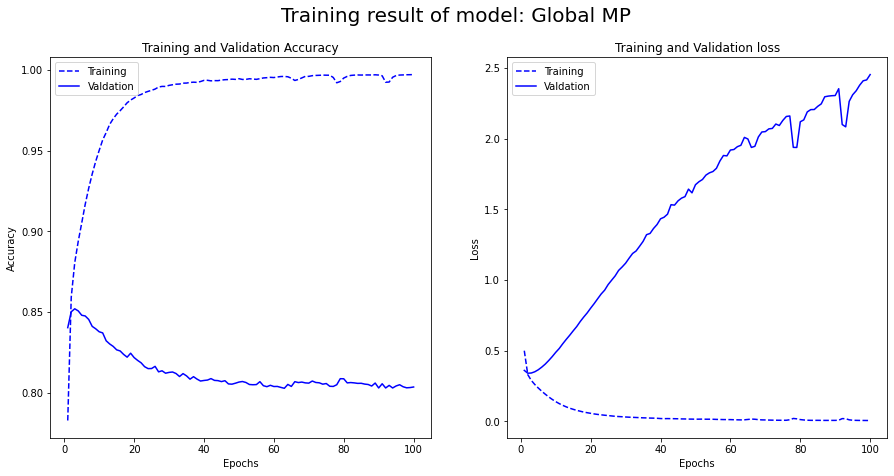

In [29]:
draw_history(history_mp, epochs, "Global MP")

In [30]:
results_cnn

[0.4822082221508026, 0.736197292804718]

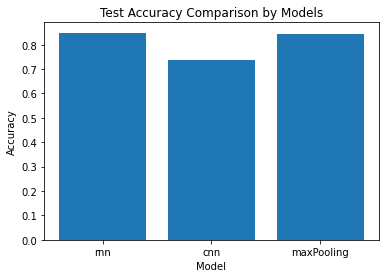

In [31]:
test_acc = {
    "rnn": results_rnn[1],
    "cnn": results_cnn[1],
    "maxPooling": results_mp[1]
}

plt.bar(test_acc.keys(), test_acc.values())
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison by Models")
plt.show()

- test 결과만 봤을 때 rnn이 가장 높고, cnn이 다른 두 모델에 비해 현저히 떨어짐!

# 7) 학습된 Embedding 레이어 분석 

In [32]:
!mkdir -p ./data
!pip list | grep gensim

gensim                        4.1.2


In [33]:
# rnn 모델 embedding layer 확인
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
weights.shape

(10000, 32)

In [34]:
word2vec_file_path = "./data/word2vec.txt"
f = open(word2vec_file_path, "w")
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_rnn.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary = False)
word_vectors.similar_by_word("영화") 

[('잘난', 0.6628895998001099),
 ('참고', 0.6538318991661072),
 ('싶', 0.6342090964317322),
 ('조지', 0.592911422252655),
 ('우드', 0.5888985991477966),
 ('닝', 0.5794137120246887),
 ('어요', 0.5794048309326172),
 ('휴머니즘', 0.5793843865394592),
 ('자주', 0.5760314464569092),
 ('아요', 0.5740282535552979)]

In [36]:
word_vectors.similar_by_word("좋")

[('타고난', 0.8726667761802673),
 ('느껴집니다', 0.8698346614837646),
 ('휴식', 0.868825376033783),
 ('요런', 0.8620811700820923),
 ('문자', 0.8581012487411499),
 ('아날로그', 0.8565062880516052),
 ('평온', 0.8562905192375183),
 ('진진', 0.851410984992981),
 ('!^^', 0.8485668897628784),
 ('정주', 0.8484460115432739)]

- "괜찮", "쩔" 처럼 긍정적인 뉘앙스가 있는 단어도 있지만, 대부분 긍정적인 것과는 거리가 있어보임

In [37]:
word_vectors.similar_by_word("별로")

[('하품', 0.9584003686904907),
 ('최시원', 0.958308219909668),
 ('실망', 0.9571210741996765),
 ('어이없', 0.9551657438278198),
 ('인내심', 0.9528496265411377),
 ('짜증', 0.9527394771575928),
 ('디워', 0.9511846899986267),
 ('광구', 0.9487884640693665),
 ('지루', 0.9468461871147156),
 ('막장', 0.9465711712837219)]

- "별로"와 유사한 단어에서 부정적인 뉘앙스를 가진 단어가 많음

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다.
    - [참고링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [38]:
ls -a ~/data

./
../
GoogleNews-vectors-negative300.bin.gz*
ratings_test.txt*
ratings_train.txt*
word2vec_ko.model
word2vec_ko.model.trainables.syn1neg.npy
word2vec_ko.model.wv.vectors.npy


In [39]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv("HOME") + "/data/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]

In [40]:
vector.shape

(100,)

In [41]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [42]:
from tensorflow.keras.initializers import Constant

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer = Constant(embedding_matrix),
                                    input_length = max_length,
                                    trainable = True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(32, activation = "relu"))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 37, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,121,409
Trainable params: 1,121,409
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit(partial_X_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/100
247/247 [==============================] - 4s 11ms/step - loss: 0.5328 - accuracy: 0.7093 - val_loss: 0.4005 - val_accuracy: 0.8191
Epoch 2/100
247/247 [==============================] - 2s 10ms/step - loss: 0.3668 - accuracy: 0.8378 - val_loss: 0.3476 - val_accuracy: 0.8465
Epoch 3/100
247/247 [==============================] - 2s 10ms/step - loss: 0.3165 - accuracy: 0.8645 - val_loss: 0.3419 - val_accuracy: 0.8506
Epoch 4/100
247/247 [==============================] - 2s 10ms/step - loss: 0.2850 - accuracy: 0.8792 - val_loss: 0.3260 - val_accuracy: 0.8600
Epoch 5/100
247/247 [==============================] - 2s 10ms/step - loss: 0.2596 - accuracy: 0.8913 - val_loss: 0.3201 - val_accuracy: 0.8638
Epoch 6/100
247/247 [==============================] - 2s 10ms/step - loss: 0.2367 - accuracy: 0.9028 - val_loss: 0.3310 - val_accuracy: 0.8643
Epoch 7/100
247/247 [==============================] - 2s 10ms/step - loss: 0.2158 - accuracy: 0.9121 - val_loss: 0.3329 - val_accuracy:

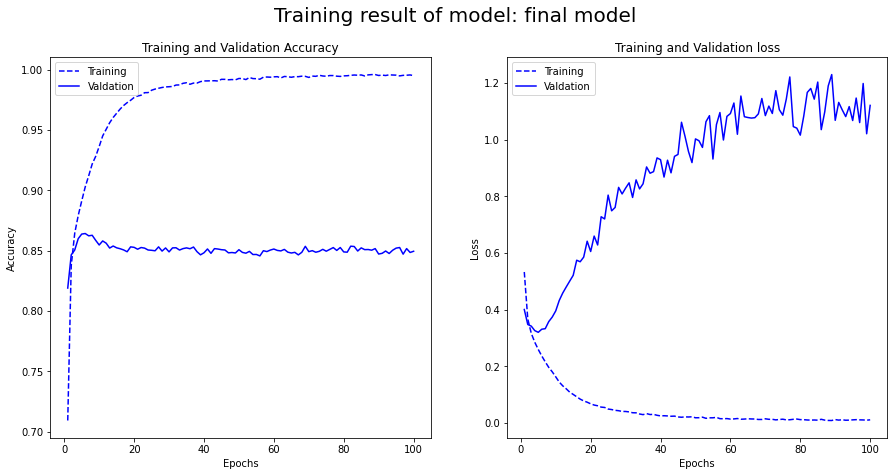

In [44]:
draw_history(history, epochs, "final model")

In [45]:
result = model.evaluate(X_test, y_test)

1537/1537 [==============================] - 4s 3ms/step - loss: 1.1556 - accuracy: 0.8458


# 9. 결론

**추가 시도 필요한 부분**
- Keras Tuner 통해서 모델의 다양한 조합을 시도해볼 것
- Train, Test, Validation dataset의 클래스 별 비중을 확인하지 못함
- EarlyStopping callback 추가
- Final 모델에 modelcheckpoint 넣는거 깜빡함...